In [1]:
from download import download
import matplotlib.pyplot as plt

import numpy as np
import mindspore as ms
import mindspore.nn as nn
import mindspore.dataset as ds
from mindspore.dataset import vision, transforms
from mindspore.train import Model, CheckpointConfig, ModelCheckpoint, LossMonitor

In [2]:
# 构建lenet5网络
class LeNet5(nn.Cell):
    def __init__(self):
        super().__init__()
        self.convseq = nn.SequentialCell(
            nn.Conv2d(1, 6, 5, stride=1, pad_mode='valid'),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5, stride=1, pad_mode='valid'),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.flat = nn.Flatten()
        self.fcseq = nn.SequentialCell(
            nn.Dense(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Dense(120, 84),
            nn.ReLU(),
            nn.Dense(84, 10)
        )
        
    def construct(self, x):
        x = self.convseq(x)
        x = self.flat(x)
        x = self.fcseq(x)
        return x

In [3]:
# 下载数据集
mnist_url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/MNIST_Data.zip"
download(mnist_url, "./data", kind="zip", replace=False)

Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.


'./data'

In [4]:
# 构建Dataset并进行图像label的处理
def create_dataset(data_path, transform, transform_label, batch_size, shuffle=True):
    data = ds.MnistDataset(dataset_dir=data_path, shuffle=shuffle)
    
    data = data.map(transform, 'image')
    data = data.map(transform_label, 'label')
    
    data = data.batch(batch_size, drop_remainder=True)
    return data

In [5]:
# 图像预处理
transform = transforms.Compose([
    vision.Resize((32, 32), interpolation=vision.Inter.LINEAR),
    vision.Rescale(1 / 0.3081, -1 * 0.1307 / 0.3081),
    vision.Rescale(1.0 / 255.0, 0.0),
    vision.Normalize(mean=(0.1307,), std=(0.3081,)),
    vision.HWC2CHW()
])
# label的预处理
type_cast_op = transforms.TypeCast(ms.dtype.int32)

In [6]:
train_dataset = create_dataset('data/MNIST_Data/train', transform, type_cast_op, 64)
test_dataset = create_dataset('data/MNIST_Data/train', transform, type_cast_op, 64)

In [7]:
img, label = next(train_dataset.create_tuple_iterator())
print(img.shape, label)

(64, 1, 32, 32) [0 4 6 4 0 6 9 5 7 9 1 0 3 2 4 3 9 8 5 7 3 9 6 0 0 7 3 6 1 4 3 0 2 3 9 7 3
 8 2 7 9 4 9 0 2 7 7 5 1 1 9 1 1 7 3 9 9 2 2 0 8 8 4 3]


In [8]:
# 展示图片函数
def plot(imgs, first_origin=None):
    num_rows = 1
    num_cols = len(imgs)

    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for idx, img in enumerate(imgs):
        ax = axs[0, idx]
        ax.imshow(img.asnumpy(), cmap='gray')
        ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if first_origin:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    plt.tight_layout()

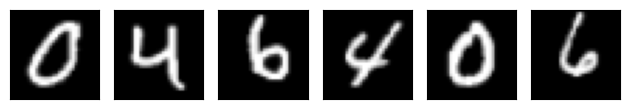

In [9]:
# 展示图片 
images = []
for image in img:
#     print("image shape", image.shape, "label shape", label.shape)
    image = np.transpose(image, (1, 2, 0))
    images.append(image)
    if len(images) > 5:
        break

plot(images)

In [10]:
# 定义letnet网络，交叉熵损失函数和Adam优化器
lenet5 = LeNet5()

loss_fn = nn.CrossEntropyLoss()

optimizer = nn.Adam(lenet5.trainable_params(), learning_rate=1e-3)

In [11]:
# 设置检查点保存模型
steps_per_epoch = train_dataset.get_dataset_size()
config = CheckpointConfig(save_checkpoint_steps=steps_per_epoch)

ckpt_callback = ModelCheckpoint(prefix="mnist", directory="./checkpoint", config=config)
loss_callback = LossMonitor(steps_per_epoch)

In [12]:
# 开始训练，边训练边评估
trainer = Model(lenet5, loss_fn=loss_fn, optimizer=optimizer, metrics={'accuracy'})

trainer.fit(10, train_dataset, test_dataset, callbacks=[ckpt_callback, loss_callback])

epoch: 1 step: 937, loss is 0.039770737290382385
Eval result: epoch 1, metrics: {'accuracy': 0.9784385005336179}
epoch: 2 step: 937, loss is 0.013771086931228638
Eval result: epoch 2, metrics: {'accuracy': 0.9884438367129136}
epoch: 3 step: 937, loss is 0.02039952576160431
Eval result: epoch 3, metrics: {'accuracy': 0.9914120864461046}
epoch: 4 step: 937, loss is 0.0034961476922035217
Eval result: epoch 4, metrics: {'accuracy': 0.9911953041622199}
epoch: 5 step: 937, loss is 0.00051126629114151
Eval result: epoch 5, metrics: {'accuracy': 0.9951640875133404}
epoch: 6 step: 937, loss is 0.03217458724975586
Eval result: epoch 6, metrics: {'accuracy': 0.994530416221985}
epoch: 7 step: 937, loss is 0.00272379070520401
Eval result: epoch 7, metrics: {'accuracy': 0.9955309498399146}
epoch: 8 step: 937, loss is 0.008720681071281433
Eval result: epoch 8, metrics: {'accuracy': 0.9957644076840982}
epoch: 9 step: 937, loss is 0.04930884391069412
Eval result: epoch 9, metrics: {'accuracy': 0.996781

In [16]:
model = LeNet5()
param_dict = ms.load_checkpoint("checkpoint/mnist-10_937.ckpt")
param_not_load, _ = ms.load_param_into_net(model, param_dict)
print(param_not_load)

[]


In [66]:
test_img, test_label = next(test_dataset.create_tuple_iterator())

In [68]:
model = Model(model)
result = model.predict(test_img)

In [69]:
print(result.argmax(1))
print(test_label)

[1 7 3 8 6 7 6 6 1 1 8 3 0 1 5 6 4 0 5 5 2 2 5 4 8 8 9 4 8 3 6 0 0 6 6 5 7
 0 5 2 3 9 1 3 1 6 8 3 2 8 0 4 4 5 0 2 8 4 7 0 2 8 4 5]
[1 7 3 8 6 7 6 6 1 1 8 3 0 1 5 6 4 0 5 5 2 2 5 4 8 8 9 4 8 3 6 2 0 6 6 5 7
 0 5 2 3 9 1 3 1 6 8 3 2 8 0 4 4 5 0 2 8 4 7 0 2 8 4 5]
